# Prophage Comparison Analysis

This jupyter notebook parses the output from [scripts/parse_prophage_predictions.pl](https://github.com/linsalrob/ProphagePredictionComparisons/blob/master/scripts/parse_prophage_predictions.pl) that makes a table with the following columns:

 - prophage caller (e.g. phispy, phage_finder, etc)
 - bacterial genome name
 - true positives (TP)
 - true negatives (TN)
 - false positives (FP)
 - false negatives (FN)
 - accuracy : the ratio of the correctly labeled phage genes to the whole pool of genes
 - precision : the ratio of correctly labeled phage genes to all predictions
 - recall : the fraction of actual phage genes we got right
 - specficity : the fraction of non phage genes we got right
 - F1 score : the harmonic mean of precision and recall, and is the best measure when, as in this case, there is a big difference between the number of phage and non-phage genes



In [1]:
import os, sys
import itertools
import re
import json
%matplotlib inline
from random import randint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
from math import log, e
from scipy import stats
from math import sqrt

## Read the results

This is the raw data. Note that `tsv` file has a header row.

In [2]:
df = pd.read_csv('all_tptn.tsv', delimiter="\t")
df.head()

,Prophage Caller,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
0,phispy,Achromobacter_denitrificans_strain_PR1,127,6276,128,0,0.980,0.498,1.000,0.980,0.665
1,phispy,Bacillus_halodurans_C-125,46,3887,299,0,0.929,0.133,1.000,0.929,0.235
2,phispy,Bacillus_subtilis_subsp._subtilis_str._168,278,4205,5,5,0.998,0.982,0.982,0.999,0.982
3,phispy,Bacteroides_uniformis_ATCC_8492_strain_81A2,103,4223,25,254,0.939,0.805,0.289,0.994,0.425
4,phispy,Bifidobacterium_longum_NCC2705,27,1790,34,51,0.955,0.443,0.346,0.981,0.388


## Plot the accuracy, precision, sensitivity, and specificity

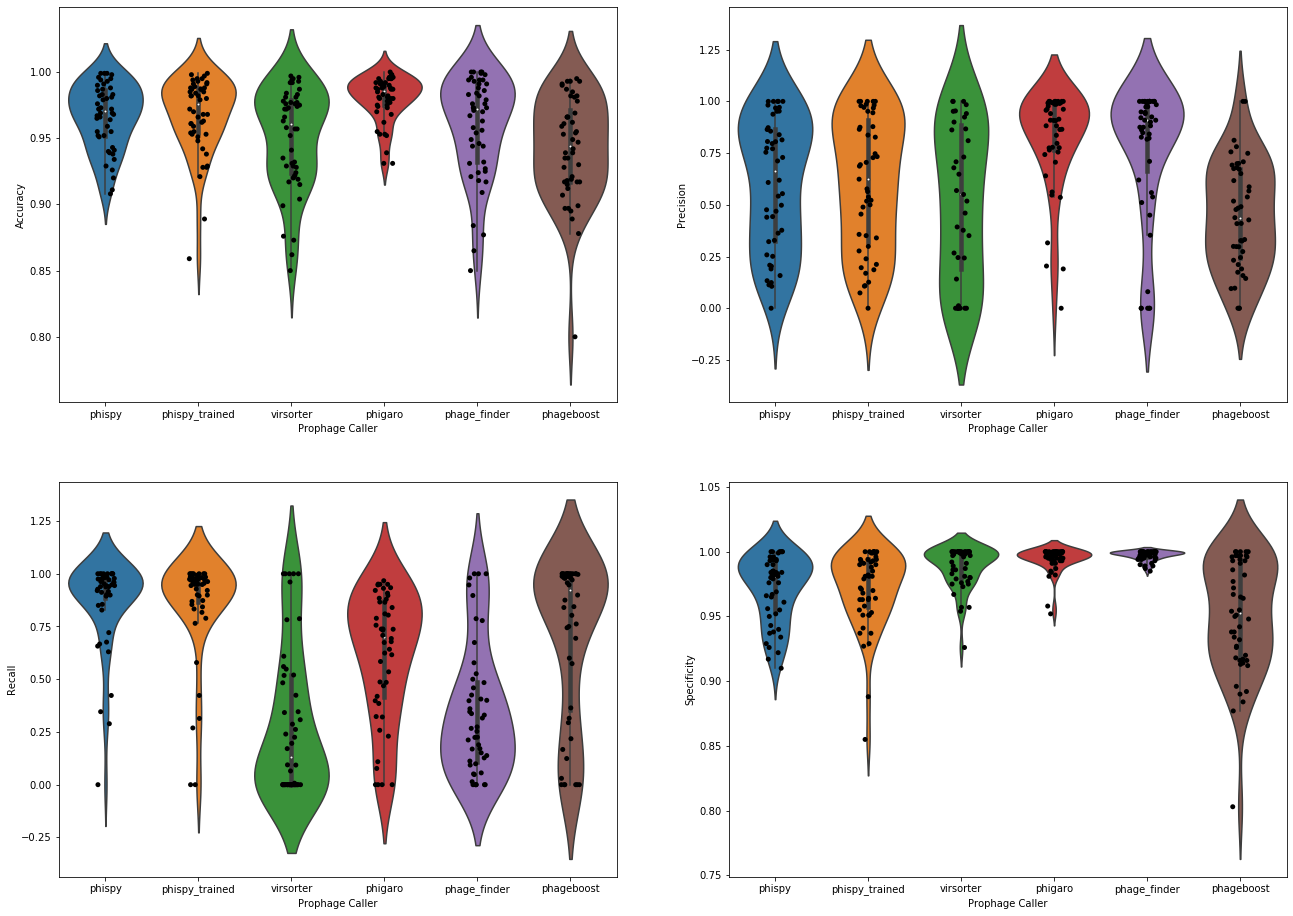

In [11]:
fig, ax = plt.subplots(2,2, figsize=(22,16))

ax_x = 0
for i, j in enumerate(df.columns[6:10]):
    if i > 1:
        ax_x = 1
        ax_y = i-2
    else:
        ax_y = i
    sns.violinplot(ax = ax[ax_x, ax_y], x="Prophage Caller", y=j, data=df, scale="count" )
    sns.stripplot(ax = ax[ax_x, ax_y], x="Prophage Caller", y=j, data=df, jitter=True, color="Black")
    #ax[ax_x, ax_y].set(ylim=(-0.39,1.39))
#fig.savefig("sensitivity_specificity.png")
fig.savefig("sensitivity_specificity_rel.png")

## F<sub>1</sub> Score

This is the most robust score since we have a lot of non-phage genes, and a relatively few phage genes.

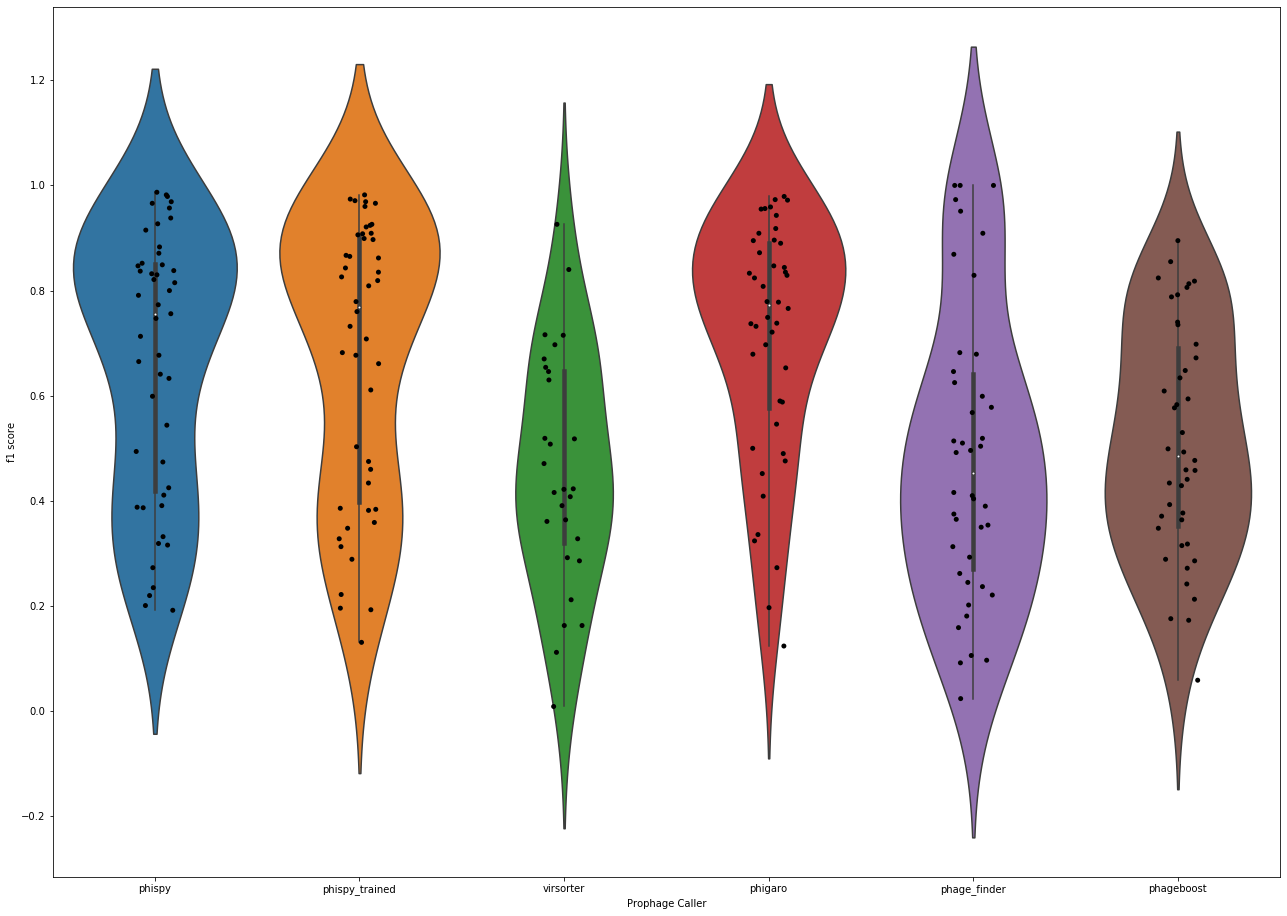

In [4]:
fig, ax = plt.subplots(figsize=(22,16))

sns.violinplot(ax = ax, x="Prophage Caller", y="f1 score", data=df, scale="count" )
sns.stripplot(ax = ax, x="Prophage Caller", y="f1 score", data=df, jitter=True, color="Black")
fig.savefig("f1_score.png")

### Show me all the data

Here is all the data!

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,Prophage Caller,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
0,phispy,Achromobacter_denitrificans_strain_PR1,127,6276,128,0,0.980,0.498,1.000,0.980,0.665
1,phispy,Bacillus_halodurans_C-125,46,3887,299,0,0.929,0.133,1.000,0.929,0.235
2,phispy,Bacillus_subtilis_subsp._subtilis_str._168,278,4205,5,5,0.998,0.982,0.982,0.999,0.982
3,phispy,Bacteroides_uniformis_ATCC_8492_strain_81A2,103,4223,25,254,0.939,0.805,0.289,0.994,0.425
4,phispy,Bifidobacterium_longum_NCC2705,27,1790,34,51,0.955,0.443,0.346,0.981,0.388
5,phispy,Brucella_melitensis_16M,33,3219,58,45,0.969,0.363,0.423,0.982,0.391
6,phispy,Caulobacter_crescentus_CB15,19,3700,39,0,0.990,0.328,1.000,0.990,0.494
7,phispy,Clostridium_perfringens_str._13,31,2728,0,12,0.996,1.000,0.721,1.000,0.838
8,phispy,Clostridium_tetani_E88,152,2532,39,14,0.981,0.796,0.916,0.985,0.852
9,phispy,Deinococcus_radiodurans_R1,0,3192,79,31,0.967,0.000,0.000,0.976,NaN


### Do all the callers identify prophages in all the genomes

Not quite. We have manually curated prophages in each of these genomes, but some of the callers fall short. This is a simple way to count those

In [6]:
df[np.isnan(df['f1 score'])].groupby('Prophage Caller').count()

,Genome,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,f1 score
Prophage Caller,,,,,,,,,,
phage_finder,6,6,6,6,6,6,5,6,6,0
phageboost,6,6,6,6,6,6,3,6,6,0
phigaro,4,4,4,4,4,4,1,4,4,0
phispy,1,1,1,1,1,1,1,1,1,0
phispy_trained,2,2,2,2,2,2,1,2,2,0
virsorter,20,20,20,20,20,20,7,20,20,0


# Speed and Memory Consumption

The accuracy is one part of the story. We also need to worry about speed and memory consumption. We leverage the benchmarking included in `snakemake` to record that data. The script [parse_benchmarks](https://github.com/linsalrob/ProphagePredictionComparisons/blob/master/scripts/parse_benchmarks.pl) will convert that data into a `tsv` file that we read here.

In [7]:
bf = pd.read_csv("all_benchmarks.tsv", delimiter="\t")
bf.head()

,Prophage Caller,Genome,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load
0,phispy,Salmonella_enterica_subsp._enterica_serovar_Ty...,226.2935,0:03:46,665.59,1022.14,629.05,632.70,0.0,0.01,108.21
1,phispy,Escherichia_coli_CFT073.benchmarks.txt,232.2258,0:03:52,675.92,1057.56,638.75,642.54,0.0,0.02,129.81
2,phispy,Xanthomonas_axonopodis_pv._citri_str._306.benc...,232.8095,0:03:52,603.18,994.86,566.56,570.21,0.0,0.02,129.43
3,phispy,Escherichia_coli_O157-H7.benchmarks.txt,240.2883,0:04:00,700.95,1057.16,663.98,667.51,0.0,0.01,121.85
4,phispy,Ralstonia_solanacearum_GMI1000.benchmarks.txt,256.5217,0:04:16,535.89,982.57,499.15,502.72,0.0,0.02,110.72


## Who is the fastest?

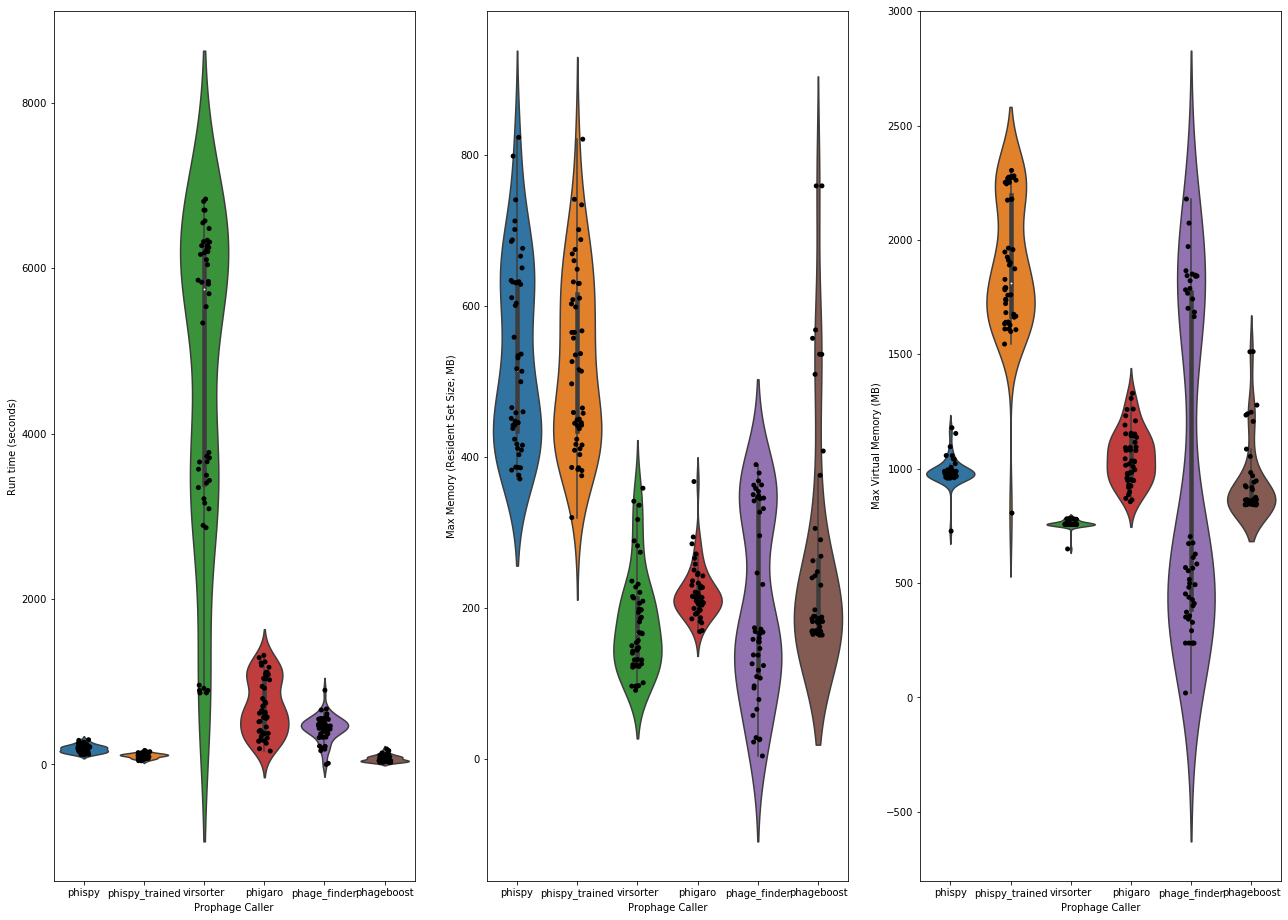

In [12]:
# here we plot all three data sets, but we really only want time and Virtual memory.
fig, ax = plt.subplots(1,3, figsize=(22,16))

labels = ["Run time (seconds)", "Max Memory (Resident Set Size; MB)", "Max Virtual Memory (MB)"]

for i, j in enumerate([bf.columns[i] for i in [2,4,5]]):
    sns.violinplot(ax = ax[i], x="Prophage Caller", y=j, data=bf, scale="count")
    sns.stripplot(ax = ax[i], x="Prophage Caller", y=j, data=bf, jitter=True, color="Black")
    ax[i].set(ylabel=labels[i])


fig.savefig("timing.png")

plt.show(fig)


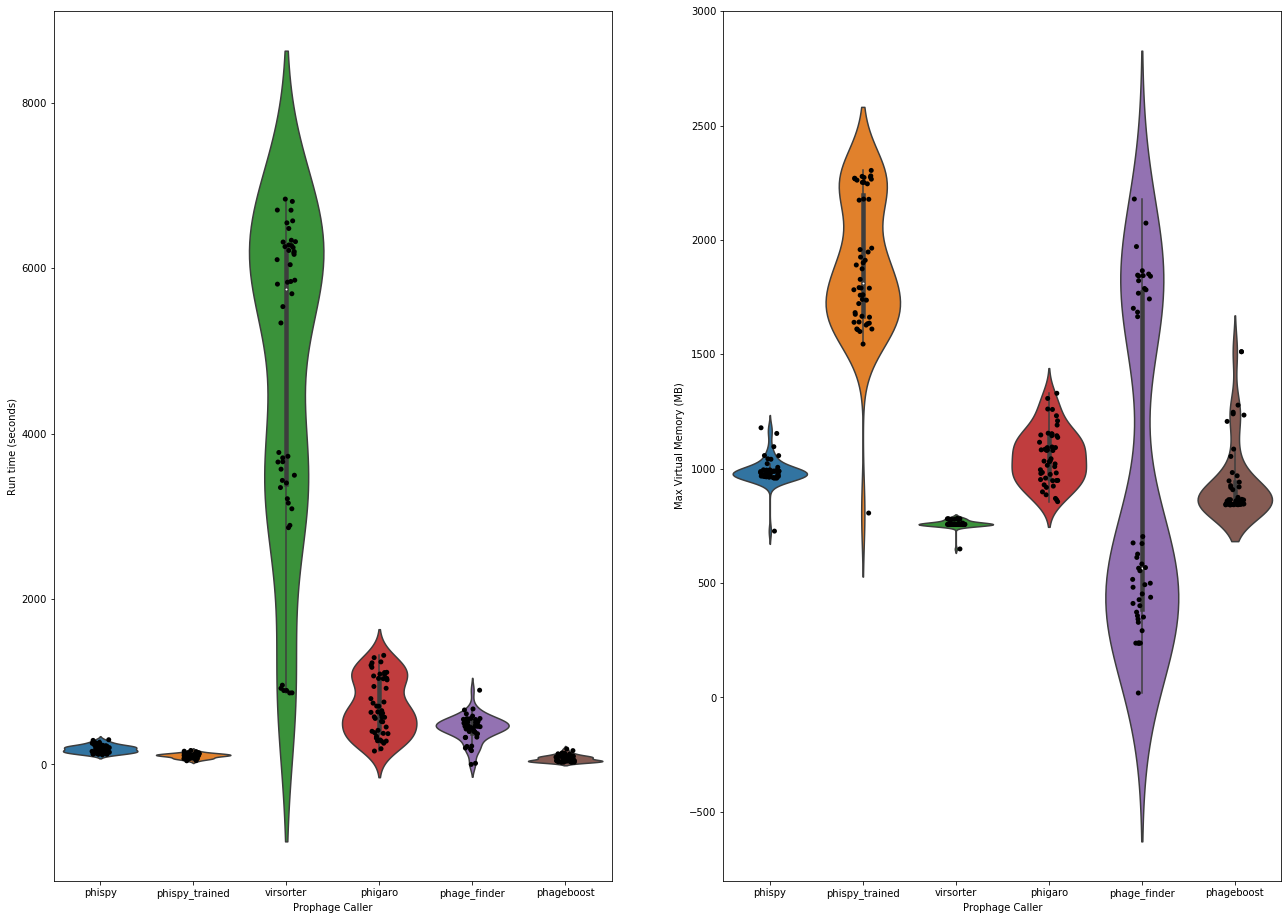

In [13]:
# here we plot time and Virtual memory.
fig, ax = plt.subplots(1,2, figsize=(22,16))

labels = ["Run time (seconds)", "Max Virtual Memory (MB)"]

for i, j in enumerate([bf.columns[i] for i in [2,5]]):
    sns.violinplot(ax = ax[i], x="Prophage Caller", y=j, data=bf, scale="count")
    sns.stripplot(ax = ax[i], x="Prophage Caller", y=j, data=bf, jitter=True, color="Black")
    ax[i].set(ylabel=labels[i])


fig.savefig("timing.png")

plt.show(fig)


In [9]:
sdf = df.groupby('Prophage Caller').describe().transpose()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(sdf)

Prophage Caller    phage_finder   phageboost      phigaro       phispy  \
TP          count     48.000000    48.000000    48.000000    48.000000   
            mean      37.145833   131.895833   119.187500   150.375000   
            std       22.853827   150.818087   134.812503   140.337227   
            min        0.000000     0.000000     0.000000     0.000000   
            25%       17.500000    33.750000    30.750000    46.000000   
            50%       38.500000    80.500000    74.500000   117.000000   
            75%       58.500000   180.250000   163.750000   215.000000   
            max       72.000000   706.000000   643.000000   689.000000   
TN          count     48.000000    48.000000    48.000000    48.000000   
            mean    3628.166667  3463.395833  3614.729167  3522.916667   
            std     1345.897934  1323.626815  1336.590275  1281.711735   
            min     1589.000000  1472.000000  1587.000000  1578.000000   
            25%     2542.750000  2383.000000  2556.500000  2519.000000   
            50%     3481.000000  3326.500000  3487.000000  3336.000000   
            75%     4439.000000  4218.500000  4400.250000  4235.250000   
            max     7663.000000  7651.000000  7641.000000  7338.000000   
FP          count     48.000000    48.000000    48.000000    48.000000   
            mean       9.250000   173.979167    22.687500   114.500000   
            std       12.924494   176.537681    40.277313   118.607882   
            min        0.000000     0.000000     0.000000     0.000000   
            25%        0.000000    22.500000     1.000000    21.750000   
            50%        3.500000   139.500000     8.000000    60.000000   
            75%       12.250000   291.750000    26.500000   183.000000   
            max       55.000000   837.000000   222.000000   418.000000   
FN          count     48.000000    48.000000    48.000000    48.000000   
            mean     135.750000    41.041667    53.708333    22.520833   
            std      147.414382    69.888348    60.096362    41.267157   
            min        0.000000     0.000000     1.000000     0.000000   
            25%       30.000000     0.750000    16.750000     2.000000   
            50%       89.500000     9.000000    34.500000     9.000000   
            75%      215.250000    47.500000    69.750000    30.000000   
            max      690.000000   320.000000   318.000000   254.000000   
Accuracy    count     48.000000    48.000000    48.000000    48.000000   
            mean       0.958854     0.942083     0.979917     0.966437   
            std        0.038435     0.039073     0.017358     0.024633   
            min        0.850000     0.800000     0.931000     0.908000   
            25%        0.931750     0.917000     0.974750     0.951750   
            50%        0.972000     0.944500     0.986000     0.970500   
            75%        0.991000     0.971250     0.992000     0.986250   
            max        1.000000     0.995000     1.000000     0.999000   
Precision   count     47.000000    45.000000    45.000000    48.000000   
            mean       0.761468     0.449689     0.817489     0.602917   
            std        0.330528     0.262166     0.242772     0.315721   
            min        0.000000     0.000000     0.000000     0.000000   
            25%        0.665000     0.245000     0.765000     0.326500   
            50%        0.909000     0.438000     0.908000     0.665500   
            75%        1.000000     0.675000     0.992000     0.866250   
            max        1.000000     1.000000     1.000000     1.000000   
Recall      count     48.000000    48.000000    48.000000    48.000000   
            mean       0.350021     0.701438     0.614792     0.866208   
            std        0.311076     0.381727     0.301145     0.212307   
            min        0.000000     0.000000     0.000000     0.000000   
            25%        0.108750     0.351750     0.413750     0.884250   
    

In [10]:
tdf = bf.groupby('Prophage Caller').describe().transpose()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(tdf)

Prophage Caller  phage_finder   phageboost      phigaro       phispy  \
s         count     47.000000    48.000000    48.000000    48.000000   
          mean     436.109330    72.344506   706.377377   190.262460   
          std      160.904673    38.998989   343.207550    46.188248   
          min        0.927700    26.185700   162.702800   116.612700   
          25%      382.383650    42.955225   396.855375   154.423125   
          50%      459.742000    61.791450   633.119350   189.485550   
          75%      519.641850    90.542475  1040.077225   218.273725   
          max      897.635200   187.582100  1318.911200   299.225100   
max_rss   count     47.000000    48.000000    48.000000    48.000000   
          mean     203.483191   260.530417   219.890833   535.007500   
          std      122.133505   157.262435    34.968446   124.452347   
          min        3.720000   163.700000   168.380000   370.490000   
          25%      113.055000   168.780000   198.665000   433.867500   
          50%      166.690000   182.460000   213.825000   514.810000   
          75%      344.895000   263.737500   230.507500   631.482500   
          max      389.500000   758.680000   367.120000   822.930000   
max_vms   count     47.000000    48.000000    48.000000    48.000000   
          mean     940.406596   943.819792  1054.778125   989.301458   
          std      700.290907   171.872485   119.373813    60.343720   
          min       19.580000   841.790000   855.970000   727.230000   
          25%      387.105000   846.280000   957.377500   966.875000   
          50%      567.960000   859.815000  1038.870000   982.595000   
          75%     1774.485000   942.650000  1144.250000   993.805000   
          max     2178.810000  1511.760000  1329.660000  1178.910000   
max_uss   count     47.000000    48.000000    48.000000    48.000000   
          mean     188.676596   204.498958   186.970833   498.018958   
          std      121.137926   157.764341    36.018250   124.475711   
          min        0.410000   106.130000   134.450000   333.010000   
          25%      100.630000   112.810000   164.700000   396.785000   
          50%      150.240000   126.480000   179.960000   477.790000   
          75%      328.660000   206.965000   199.277500   594.382500   
          max      376.960000   701.500000   332.610000   785.800000   
max_pss   count     47.000000    48.000000    48.000000    48.000000   
          mean     189.800000   210.383333   189.390000   502.404583   
          std      120.959187   157.744826    35.838202   124.434233   
          min        0.590000   112.190000   136.620000   336.910000   
          25%      101.380000   118.402500   166.300000   400.945000   
          50%      151.370000   132.100000   181.330000   481.375000   
          75%      329.475000   213.077500   202.137500   599.585000   
          max      377.700000   708.120000   336.200000   789.660000   
io_in     count     47.000000    48.000000    48.000000    48.000000   
          mean       4.271489     1.375208    10.053958     0.000000   
          std        2.354401     1.044188    30.569169     0.000000   
          min        0.000000     0.000000     0.000000     0.000000   
          25%        2.670000     0.017500     1.810000     0.000000   
          50%        3.130000     1.455000     3.630000     0.000000   
          75%        6.240000     2.225000     5.630000     0.000000   
          max        9.590000     3.090000   201.680000     0.000000   
io_out    count     47.000000    48.000000    48.000000    48.000000   
          mean       9.149149     0.010625     6.202292     0.012917   
          std        6.652923     0.002446     2.224721     0.004593   
          min        0.000000     0.010000     2.990000     0.010000   
          25%        6.270000     0.010000     4.572500     0.010000   
          50%        8.290000     0.010000     5.965000     0.010000   
          75%       10.125000     0.0100